In [63]:
%load_ext autoreload
%autoreload 2
import gzip
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from numba import cuda
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import find_peaks, decimate

import stumpy

from detectors.motives import MotifFinder
from readers.base import NeuralynxReader, OpenEphysReader
from clusterers.brain_behavior import BrainBehavior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
sources = {
  'stella': ('/media/sil2/Data/Lizard/Stellagama/SA09_SA07/SA07_SA09_17_06_21_Trial11_Trial25_27D/Record Node 117', 17, OpenEphysReader),
  'mark_pogona': ('/media/sil2/Data/Lizard/Pogona Data/Lizard15/12.14.2015/18-26-12_cheetah', 32, NeuralynxReader),
  'lorenz_pogona1': ('/media/sil2/Data/Lizard/lorenz_data/2019-11-17_17-43-33', 31, NeuralynxReader),
  'lorenz_pogona2': ('/media/sil2/Data/Lizard/lorenz_data/2020-10-31_18-01-59', 64, NeuralynxReader),
  'lorenz_no_claustrum': ('/media/sil2/Data/Lizard/lorenz_data/2019-10-21_18-00-39', 31, NeuralynxReader)
}

In [72]:
%%time
rootdir, channel, reader_cls = sources['lorenz_pogona2']
rd = reader_cls(rootdir, channel=channel)
sc = rd.load_slow_cycles()
print(f'Reader initialized. fs={rd.fs:.0f}Hz, duration={rd.time_vector[-1]/3600:.1f} hours, #Cycles={len(sc)}')

Reader initialized. fs=32000Hz, duration=15.7 hours, #Cycles=225
CPU times: user 14.6 s, sys: 4.62 s, total: 19.2 s
Wall time: 19.2 s


In [74]:
cache_dir = '/home/regev/PycharmProjects/lfp_clustering/output/motives/20220519/183526' # lorenz1 from 8 cycles
with gzip.open(f'{cache_dir}/cache_fields.gz', 'rb') as f:
    cache = pickle.load(f)

idx = [0, 21, 23]
motives, windows = [cache['motives'][i] for i in idx], [cache['windows'][i] for i in idx]
mf = MotifFinder(rd, decimate_q=15, lowpass=50, filter_order=5)
mf.motives, mf.windows = motives, windows

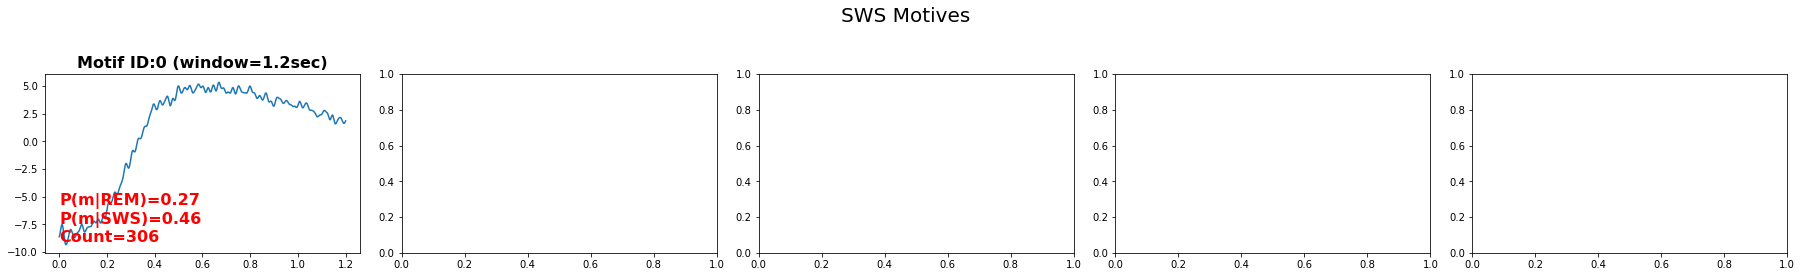

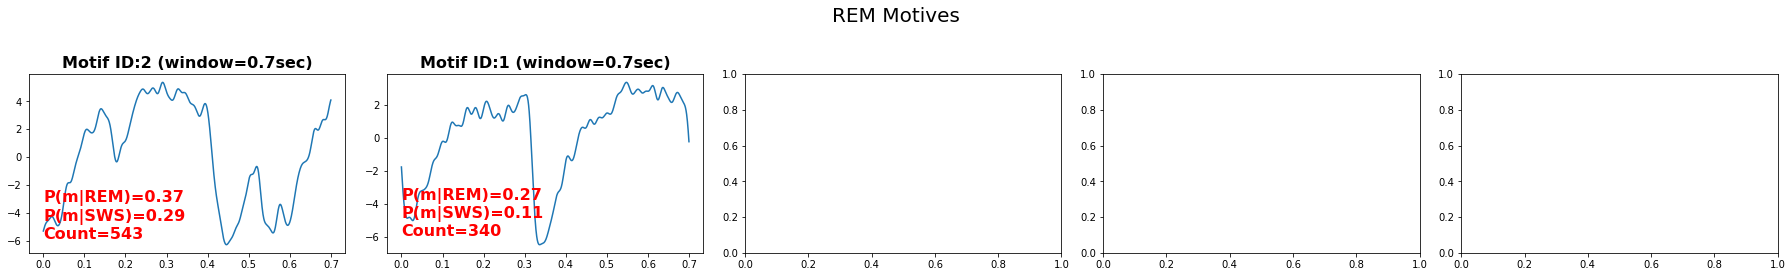

In [81]:
cycle_id = 100
mf.plot_search_summary(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+8, 'off'])

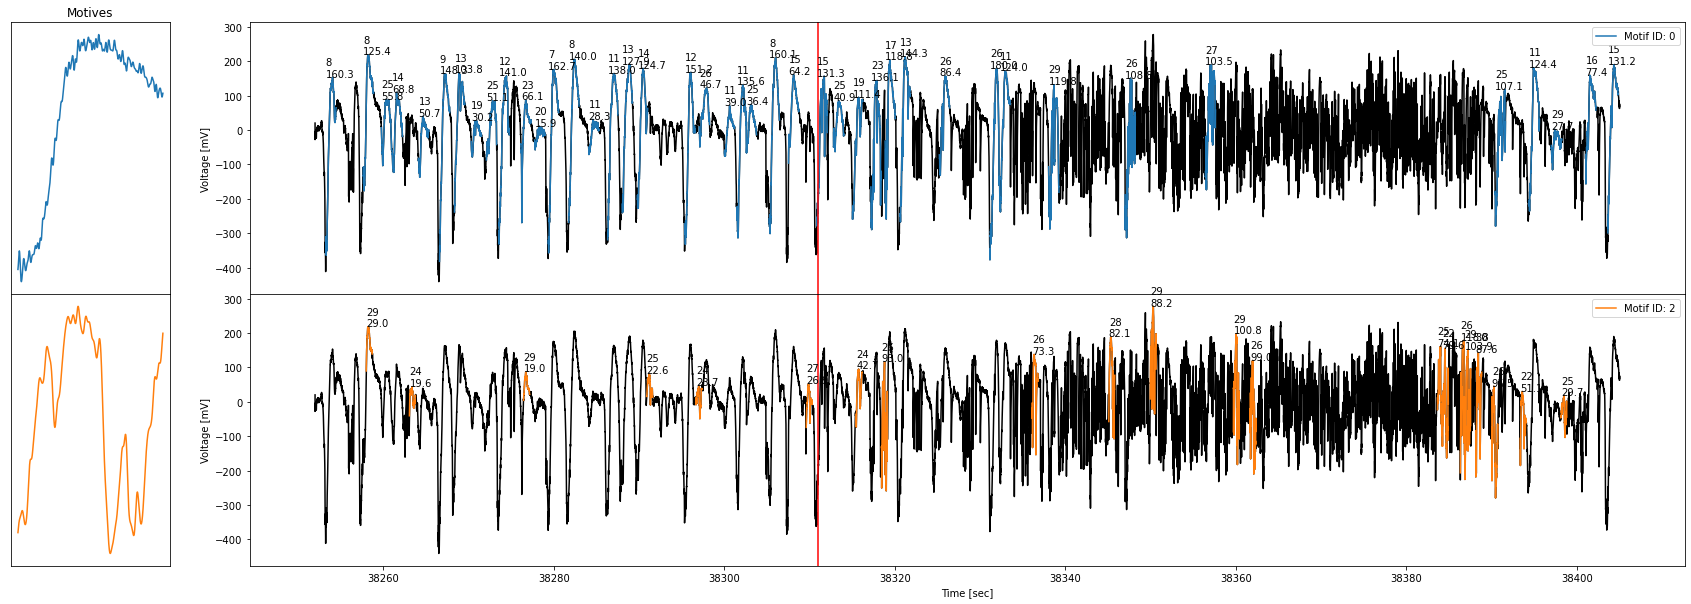

In [79]:
mf.plot_labelled_cycle(cycle_id=200, motives_ids=[0, 2], max_dist=30, is_separate=True)

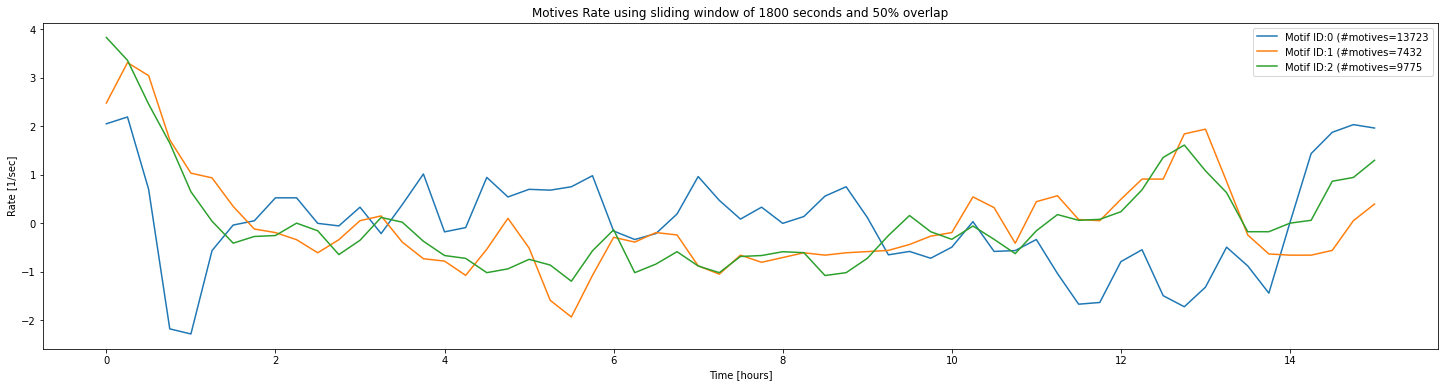

In [82]:
mf.plot_motif_rate_vs_time([0,1,2], max_dist=30, rate_window=30*60, is_normalize=True)

No rem motives were found


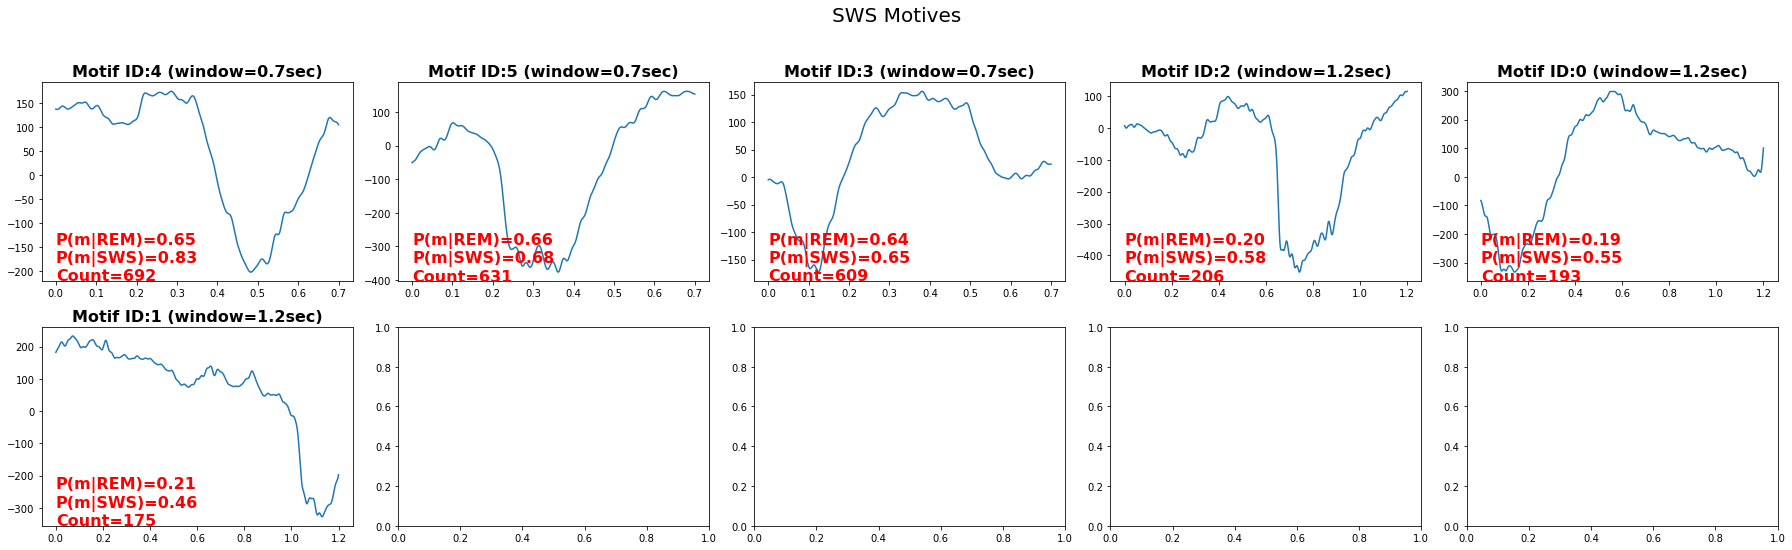

In [62]:
# cache_dir = '/home/regev/PycharmProjects/lfp_clustering/output/motives/20220519/183526' # lorenz1 from 8 cycles
cache_dir = '/home/regev/PycharmProjects/lfp_clustering/output/motives/20220521/114412' # mark from 8 cycles
mf = MotifFinder(cache_dir=cache_dir)
sc = mf.rd.load_slow_cycles()
cycle_id = 10 #len(sc) // 2
mf.plot_search_summary(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+8, 'off'])

In [ ]:
%%time

def analyse_ext_motives(source, cycle_id=100):
  rootdir, channel, reader_cls = sources[source]
  rd = reader_cls(rootdir, channel=channel)
  sc = rd.load_slow_cycles()
  print(f'Reader initialized. fs={rd.fs:.0f}Hz, duration={rd.time_vector[-1]/3600:.1f} hours, #Cycles={len(sc)}')
  cache_dir = '/home/regev/PycharmProjects/lfp_clustering/output/motives/20220519/183526' # lorenz1 from 8 cycles
  with gzip.open(f'{cache_dir}/cache_fields.gz', 'rb') as f:
      cache = pickle.load(f)
  idx = [0, 21, 23]
  motives, windows = [cache['motives'][i] for i in idx], [cache['windows'][i] for i in idx]
  mf = MotifFinder(rd, decimate_q=15, lowpass=50, filter_order=5)
  mf.motives, mf.windows = motives, windows
  mf.plot_search_summary(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+8, 'off'])
  mf.plot_labelled_cycle(cycle_id=200, motives_ids=[0, 2], max_dist=30, is_separate=True)

analyse_ext_motives('mark_pogona')

Finish calculating matrix profile with window of 1.2 seconds in 12.4 minutes.
Finish calculating matrix profile with window of 0.7 seconds in 3.5 minutes.
CPU times: user 13min 17s, sys: 3min 1s, total: 16min 18s
Wall time: 16min 19s


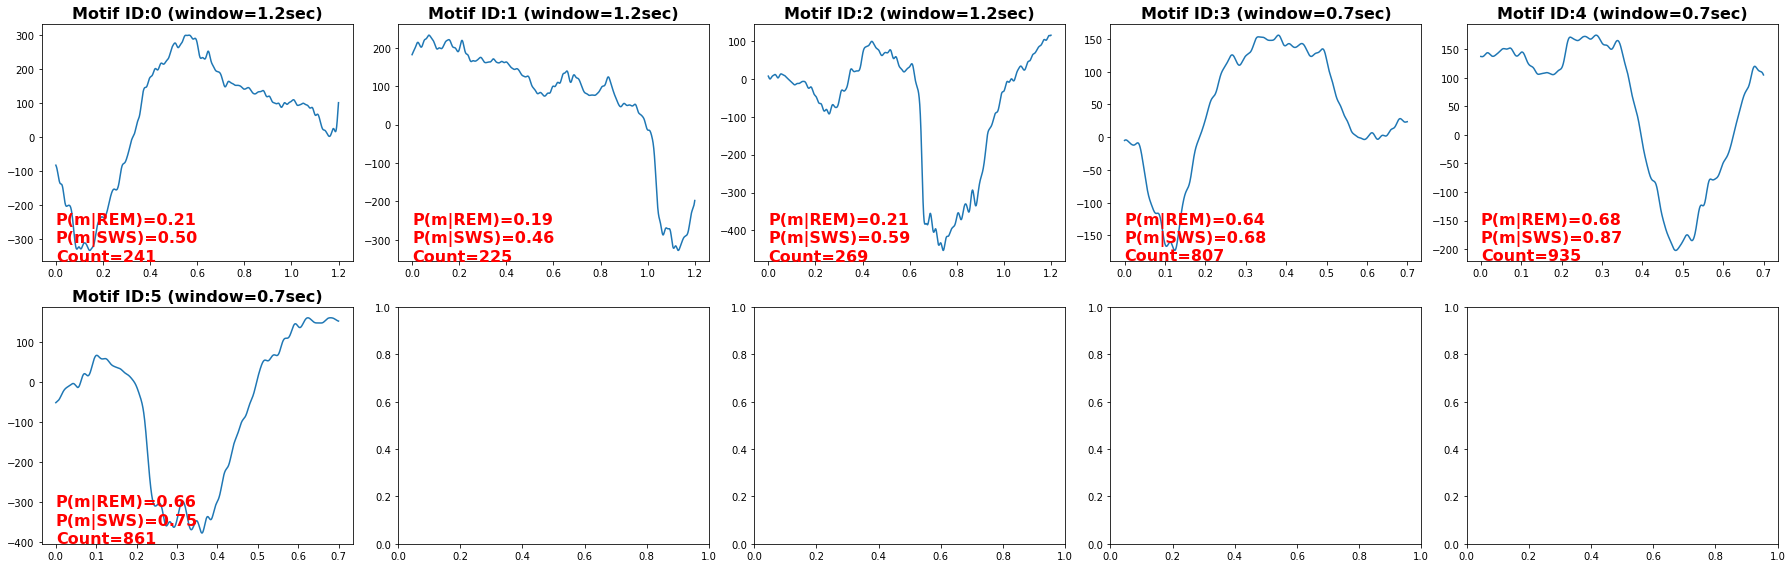

In [34]:
%%time
%matplotlib inline
mf = MotifFinder(rd, decimate_q=15, lowpass=50, filter_order=5)
cycle_id = len(sc) // 2
cache_dir = mf.search(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+8, 'off'],
                       durations=[1.2,0.7], durations2remove=[1.2],
                       is_cache=True, is_avg_motives=False, is_remove_corr=True, external_motives=())

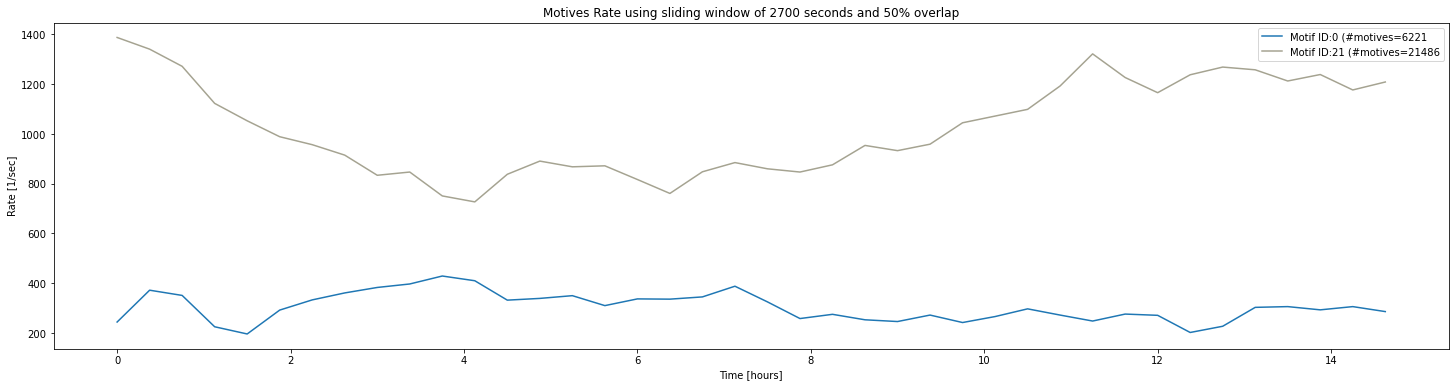

In [27]:
mf.plot_motif_rate_vs_time([0,21], max_dist=[30,35], rate_window=30*60, is_normalize=True)

Finish calculating matrix profile with window of 1.2 seconds in 2.9 minutes.
Finish calculating matrix profile with window of 0.9 seconds in 1.9 minutes.
Finish calculating matrix profile with window of 0.8 seconds in 1.9 minutes.
Finish calculating matrix profile with window of 0.7 seconds in 1.9 minutes.


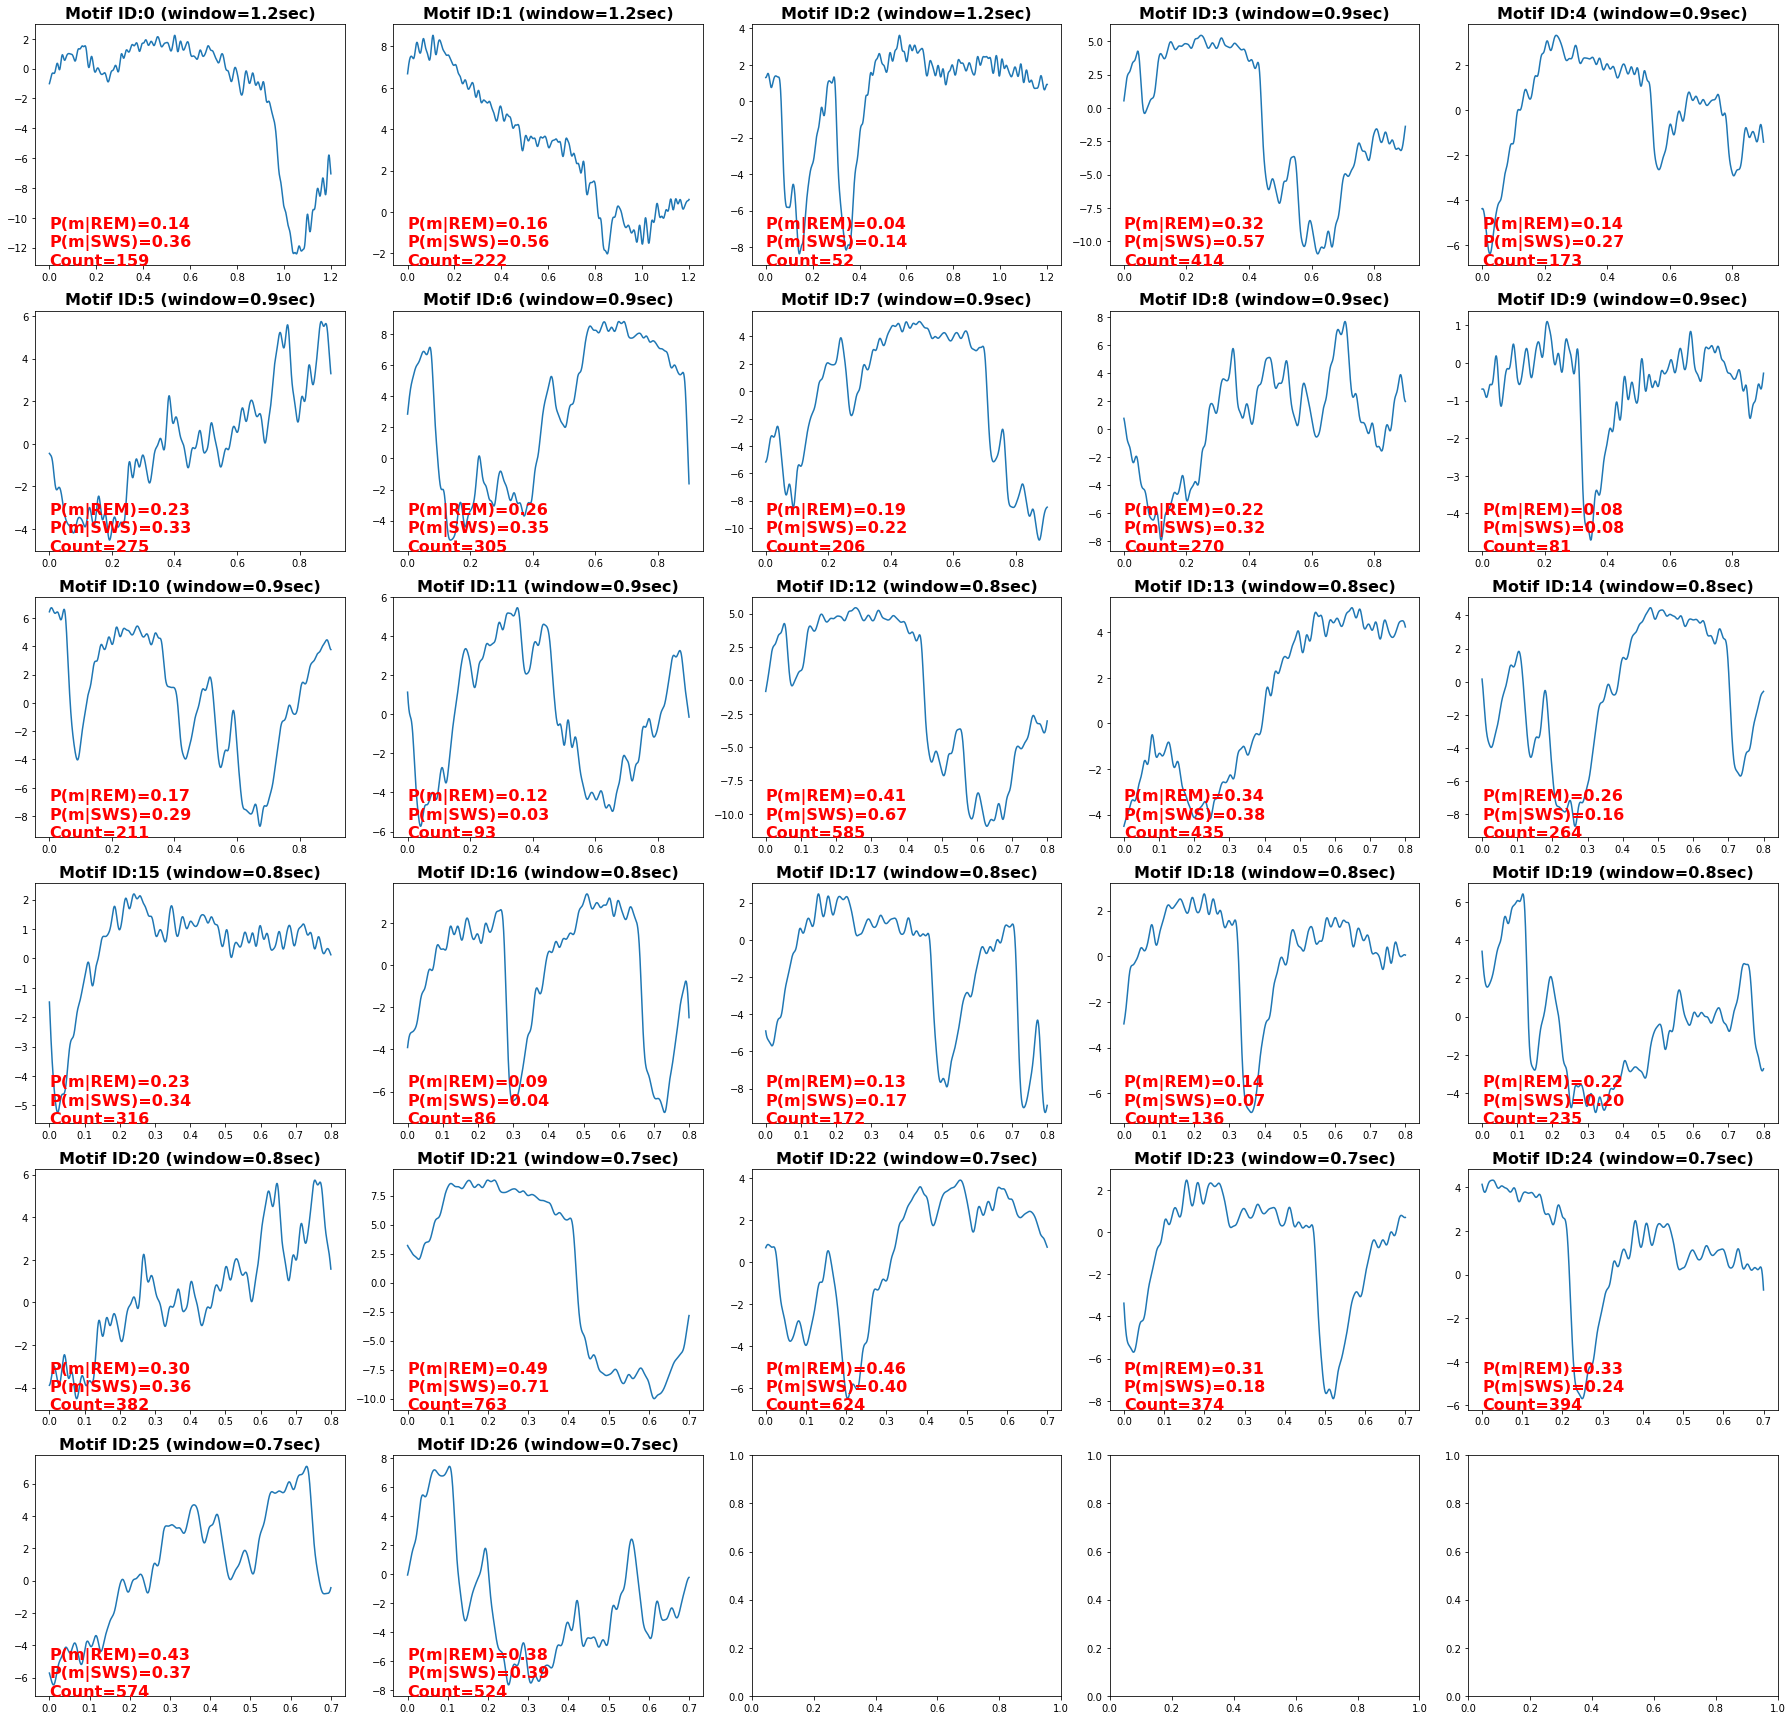

In [24]:
# search only in REM
v = []
mf = MotifFinder(rd, decimate_q=15, lowpass=50, filter_order=5)
cycle_id = len(sc) // 2
for cycle_id in range(cycle_id, cycle_id+4):
  v_, _ = mf.read_signal(t_start=sc.loc[cycle_id, 'mid'], t_stop=sc.loc[cycle_id, 'off'])
  v.append(np.append(v_, np.nan))
v = np.hstack(v)
cache_dir = mf.search(v=v, durations=[1.2,0.9,0.8,0.7], durations2remove=[1.2],
                      t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+4, 'off'],
                      is_cache=True, is_avg_motives=False, is_remove_corr=True, external_motives=())

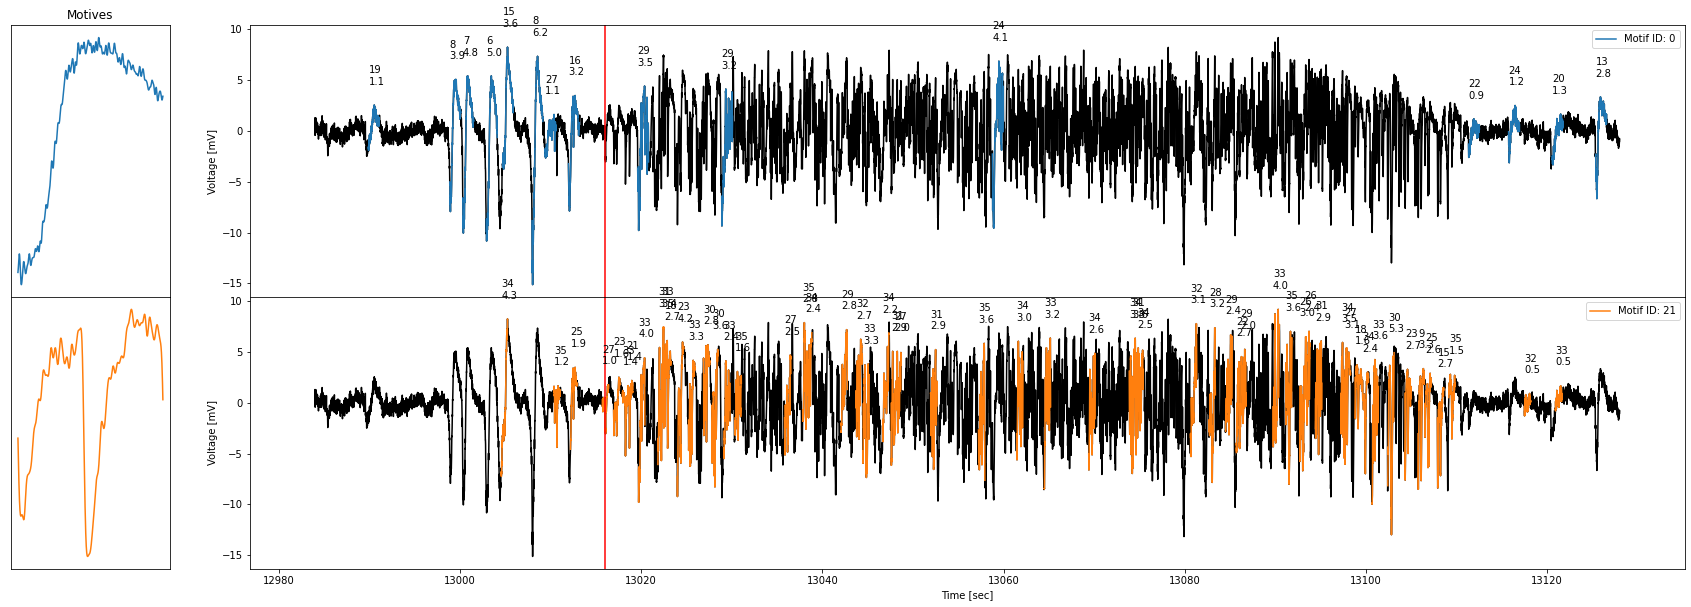

In [26]:
%matplotlib inline
mf.plot_labelled_cycle(cycle_id=42, motives_ids=[0,21],
                       max_dist=[30, 35], is_separate=True) #colors={0: 'tab:blue', 2: 'tab:orange'}

In [ ]:
bb = BrainBehavior(recording_path='/home/regev/PycharmProjects/lfp_clustering/output/motives/20220519/183526',
                   video_file='/media/sil2/Data/Lizard/lorenz_data/2020-10-31_18-01-59/regev_cache/resnet_features/20220516T232954.h5')


IndexError: index 2259227 is out of bounds for axis 0 with size 2233518

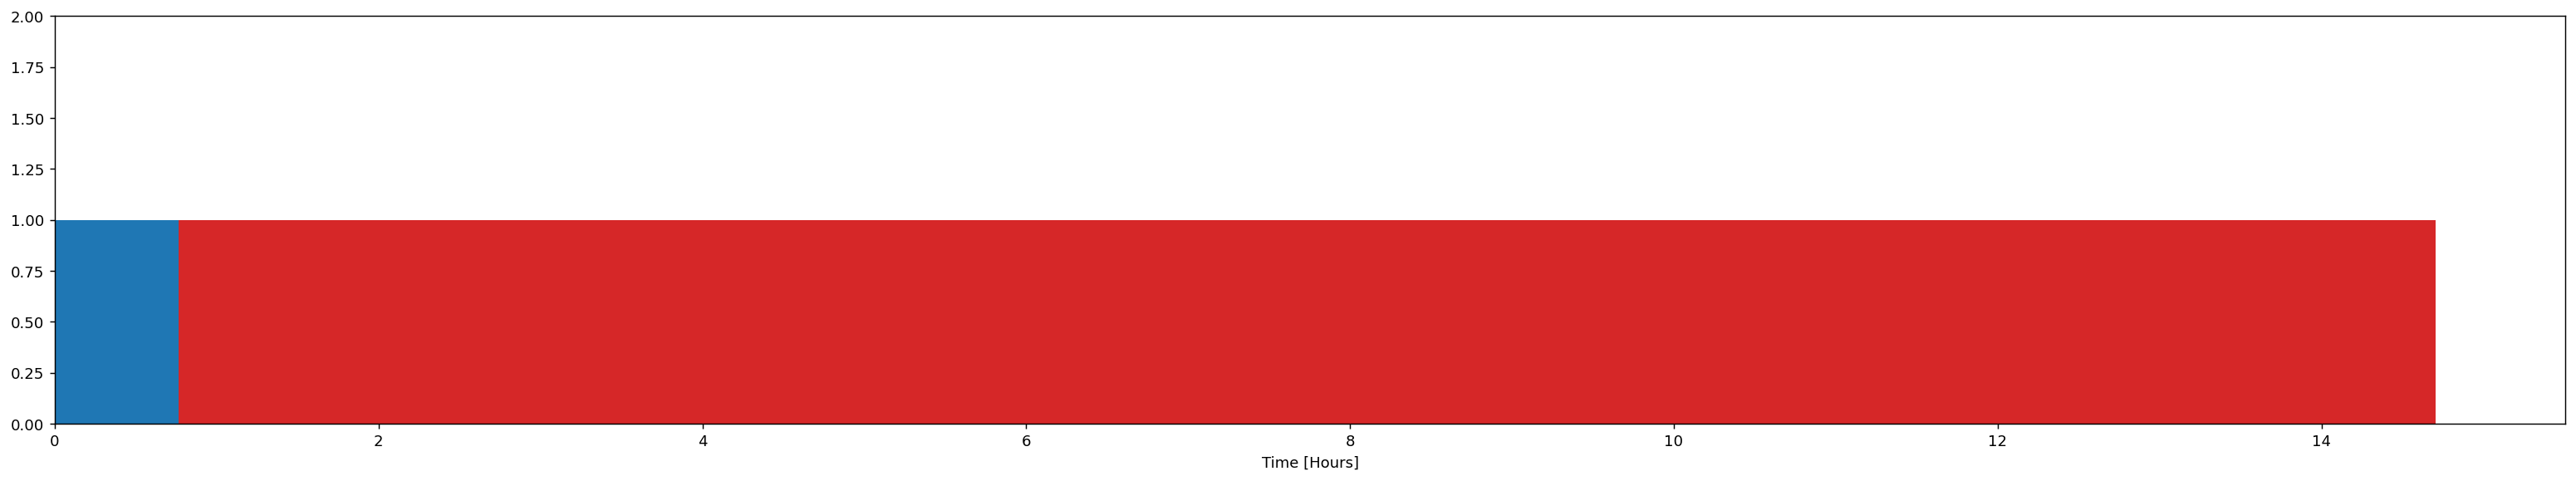

In [71]:
bb.plot_temporal()

In [191]:
t_start, t_stop = sc.loc[cycle_id, 'on'], sc.loc[cycle_id, 'off']
v, t = mf2.read_signal(t_start=t_start, t_stop=t_stop)
print(t_start, t[0])
print(t_stop, t[-1])

12984.0 12984.0
13128.0 13127.99996875


In [192]:
from scipy.signal import decimate, resample

v_, t_ = resample(v, len(v)//15, t)
print(t_start, t_[0])
print(t_stop, t_[-1])

12984.0 12984.0
13128.0 13127.999529707735


In [193]:
print(len(t), len(t_))

4608000 307200


In [180]:
int(t_start * mf2.rd.fs)

415488000

Finish calculating matrix profile with window of 1.2 seconds in 8.7 minutes.
Finish calculating matrix profile with window of 1 seconds in 1.7 minutes.
Finish calculating matrix profile with window of 0.7 seconds in 1.6 minutes.
CPU times: user 10min 41s, sys: 1min 32s, total: 12min 13s
Wall time: 12min 13s


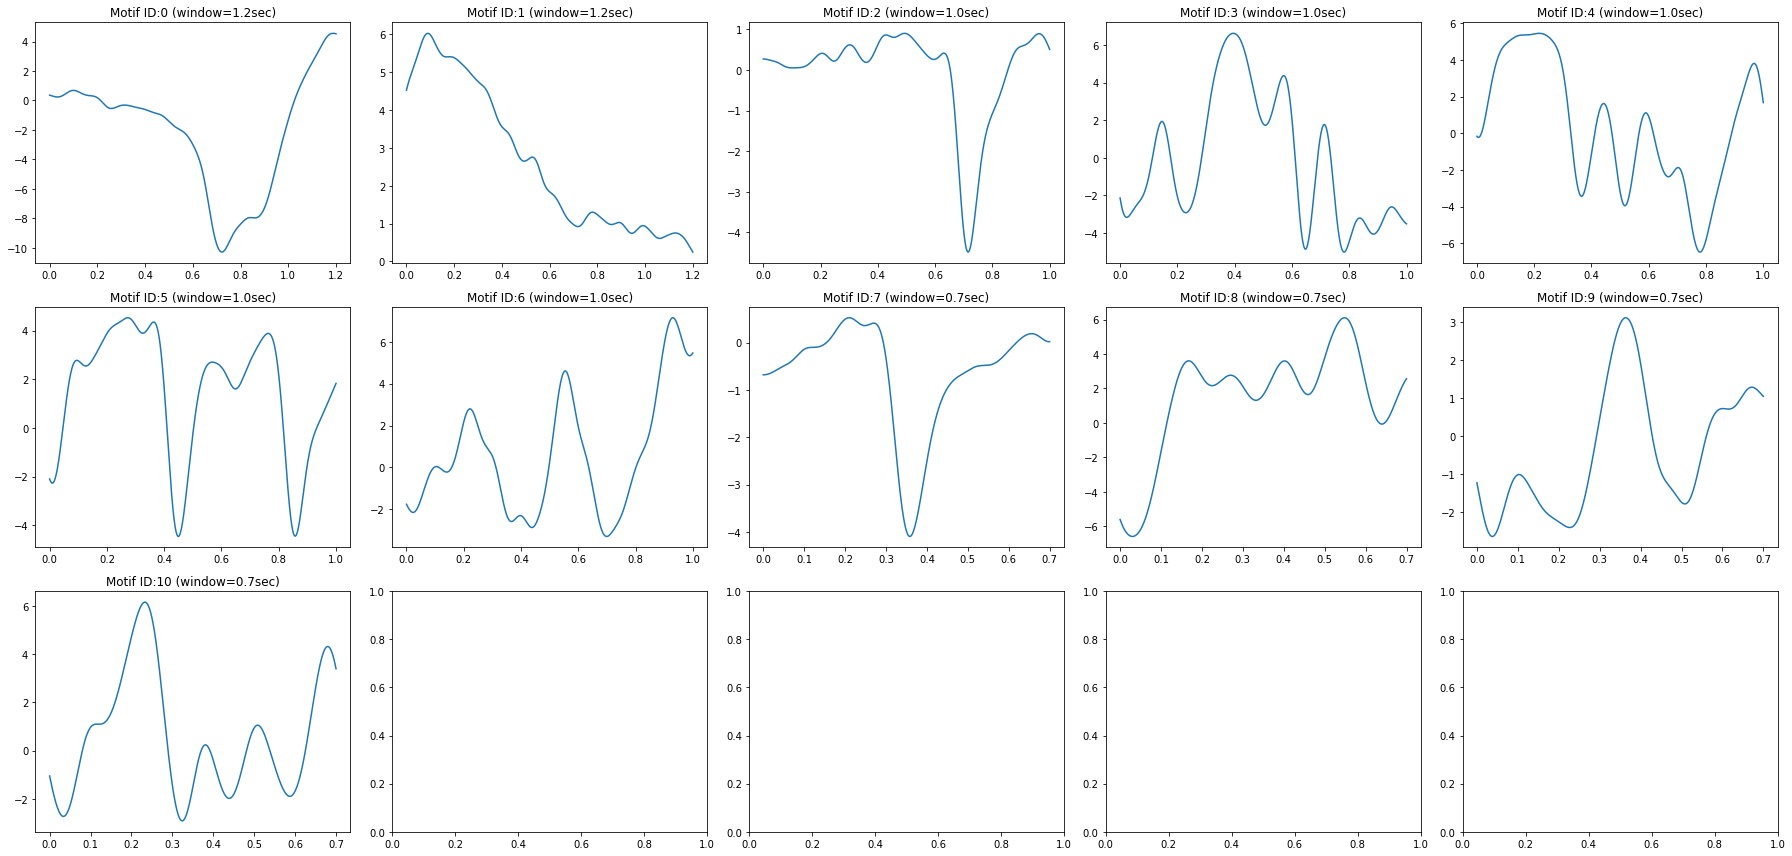

In [21]:
%%time
%matplotlib inline
cycle_id = len(sc) // 2
mf = MotifFinder(rd, decimate_q=15, lowpass=10, filter_order=3)
cache_dir = mf.search(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+4, 'off'], durations=[1.2,1,0.7],
                      durations2remove=[1.2], is_cache=True, is_avg_motives=False, is_remove_corr=True)
mf.plot_found_motives()

Motif ID: 0; Finish mass motif search in 0.0 minutes. # of motives found: 10
Motif ID: 5; Finish mass motif search in 0.0 minutes. # of motives found: 6


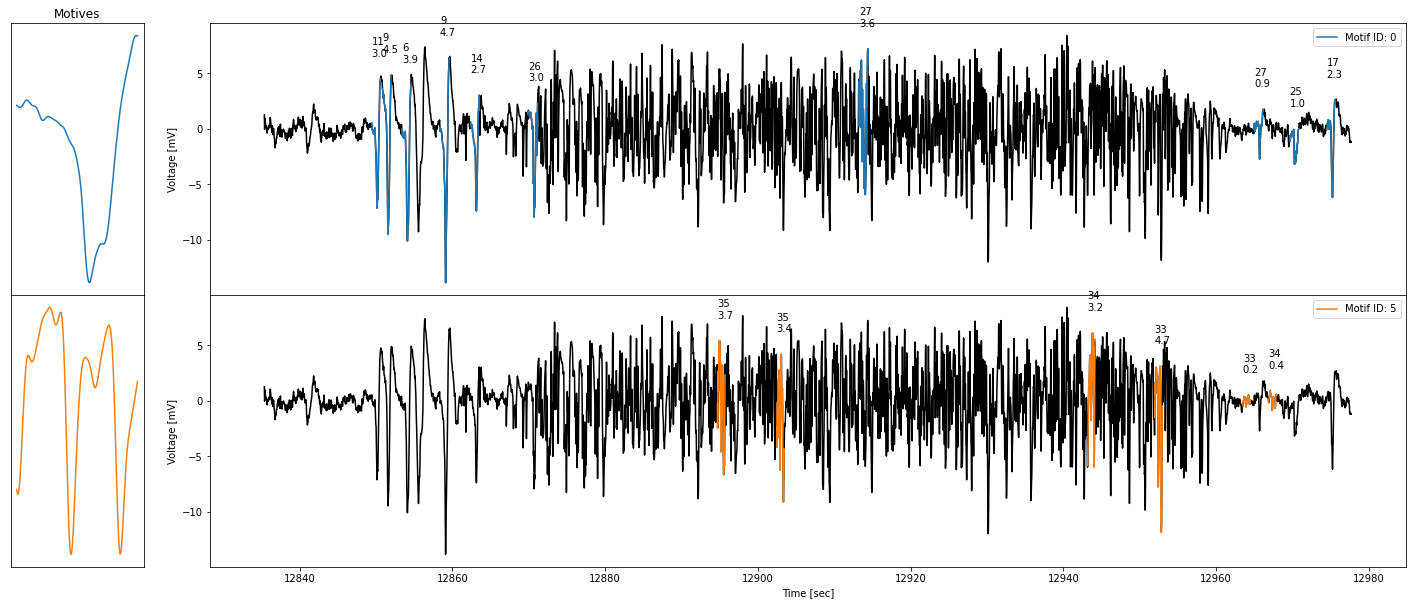

In [30]:
%matplotlib inline
cycle_id = 42
mf.plot_labelled_signal(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id, 'off'], motives_ids=[0,5],
                        max_dist=[30,35], is_separate=True) #colors={0: 'tab:blue', 2: 'tab:orange'}

array([ True,  True,  True, ...,  True,  True,  True])

In [4]:
%%time
cycle_id = 50

for rootdir, channel in sources:
  try:
    rd = NeuralynxReader(rootdir, channel=channel)
    sc = rd.load_slow_cycles()
    print(f'Reader initialized. fs={rd.fs:.0f}Hz, duration={rd.time_vector[-1]/3600:.1f} hours')
    mf = MotifFinder(rd, decimate_q=15, lowpass=50, filter_order=3)
    cache_dir = mf.search(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+10, 'off'], durations=[1.2,1,0.7,0.4,0.2],
                          durations2remove=[1.2], is_cache=True)
  except Exception as exc:
    print(f'ERROR in {rootdir}: {exc}')

Reader initialized. fs=32000Hz, duration=17.1 hours
Finish calculating matrix profile with window of 1.2 seconds in 13.4 minutes.
Finish calculating matrix profile with window of 1 seconds in 1.7 minutes.
Finish calculating matrix profile with window of 0.7 seconds in 1.7 minutes.
Finish calculating matrix profile with window of 0.4 seconds in 1.7 minutes.
Finish calculating matrix profile with window of 0.2 seconds in 1.8 minutes.
Reader initialized. fs=32000Hz, duration=15.5 hours
Finish calculating matrix profile with window of 1.2 seconds in 66.7 minutes.
Finish calculating matrix profile with window of 1 seconds in 14.5 minutes.
Finish calculating matrix profile with window of 0.7 seconds in 14.5 minutes.
Finish calculating matrix profile with window of 0.4 seconds in 14.6 minutes.
Finish calculating matrix profile with window of 0.2 seconds in 14.6 minutes.
Reader initialized. fs=32000Hz, duration=16.2 hours
Finish calculating matrix profile with window of 1.2 seconds in 69.2 min

In [9]:
mf.cache_dir = mf.get_cache_dir()
mf.save_cache()

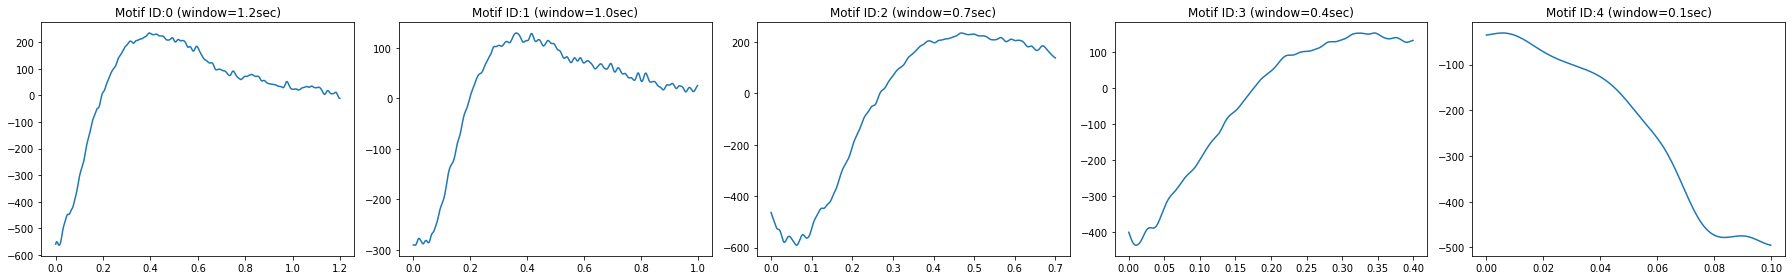

In [14]:
cache_dir = '../output/motives/20220503/162534'
mf = MotifFinder(cache_dir=cache_dir)
sc = mf.rd.load_slow_cycles()
mf.plot_found_motives()

Motif ID: 0; Finish mass motif search in 0.0 minutes. # of motives found: 32


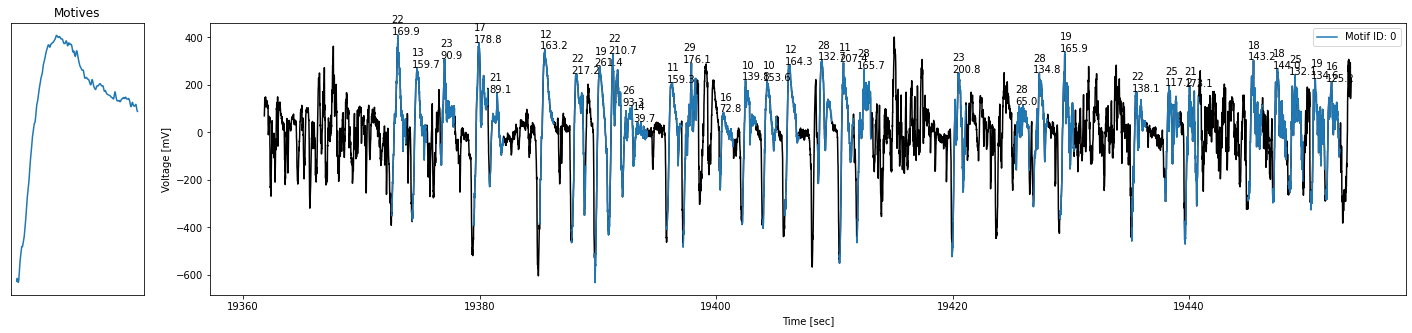

In [21]:
%matplotlib inline
cycle_id = 40
mf.plot_labelled_signal(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id, 'off'], motives_ids=[0],
                        max_dist=[30], colors={0: 'tab:blue', 10: 'tab:red'}, is_separate=True)

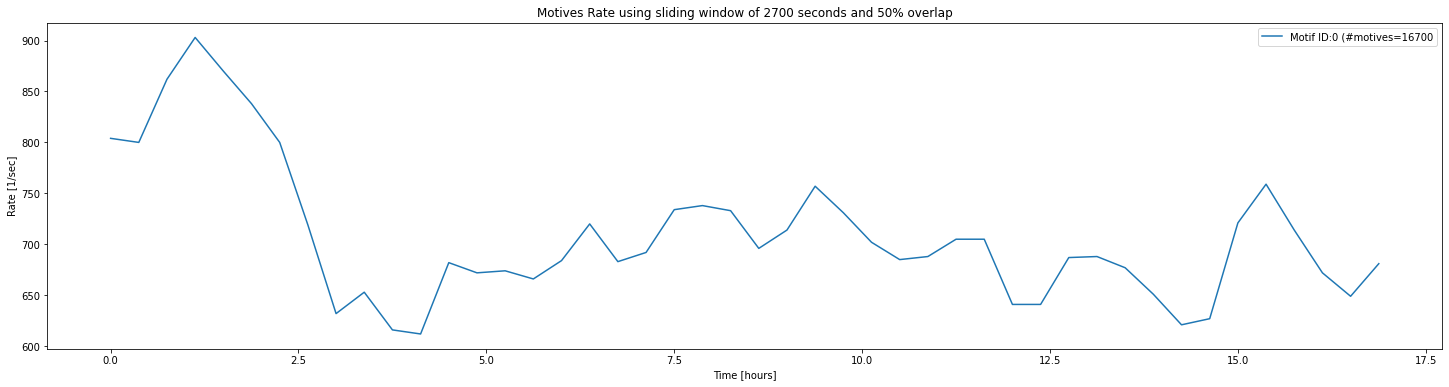

In [23]:
mf.plot_motif_rate_vs_time([0], max_dist=25, rate_window=45*60, colors={0: 'tab:blue', 10: 'tab:red'}, is_normalize=False)

In [134]:
cycle_id = 0
motives, P = mf.calc_overlap_motives(t_start=sc.loc[cycle_id, 'on'], t_stop=sc.loc[cycle_id+2, 'off'],
                                     max_overlap=0.5, max_dist=40)
with np.printoptions(precision=2, suppress=True):
    print(P)
motives

AttributeError: 'MotifFinder' object has no attribute 'calc_overlap_motives'

In [158]:
from pickle import dump

with Path('../output/motives/pogona1.pkl').open('wb') as f:
  dump({'mf': mf}, f)

In [55]:
for i in range(P.shape[0]):
  for j in range(P.shape[0]):
    if i == j:
      continue
    elif P[i, j] > 0.5:
      print(f'{i}->{j}: {P[i, j]:.0%}  |  {j}->{i}: {P[j, i]:.0%}')

0->1: 54%  |  1->0: 58%
0->6: 66%  |  6->0: 21%
0->7: 63%  |  7->0: 23%
0->8: 74%  |  8->0: 21%
0->9: 62%  |  9->0: 21%
0->10: 64%  |  10->0: 24%
0->11: 71%  |  11->0: 22%
0->12: 71%  |  12->0: 20%
0->13: 70%  |  13->0: 20%
1->0: 58%  |  0->1: 54%
1->6: 65%  |  6->1: 19%
1->7: 61%  |  7->1: 20%
1->8: 72%  |  8->1: 19%
1->9: 63%  |  9->1: 20%
1->10: 60%  |  10->1: 21%
1->11: 66%  |  11->1: 19%
1->12: 72%  |  12->1: 19%
1->13: 70%  |  13->1: 19%
2->1: 53%  |  1->2: 44%
2->6: 73%  |  6->2: 18%
2->7: 50%  |  7->2: 14%
2->8: 68%  |  8->2: 15%
2->9: 69%  |  9->2: 18%
2->10: 58%  |  10->2: 17%
2->11: 65%  |  11->2: 16%
2->12: 75%  |  12->2: 16%
2->13: 78%  |  13->2: 17%
3->6: 72%  |  6->3: 22%
3->8: 57%  |  8->3: 16%
3->9: 70%  |  9->3: 23%
3->12: 73%  |  12->3: 20%
3->13: 74%  |  13->3: 20%
4->0: 61%  |  0->4: 42%
4->6: 74%  |  6->4: 16%
4->7: 57%  |  7->4: 14%
4->8: 71%  |  8->4: 14%
4->9: 71%  |  9->4: 16%
4->10: 51%  |  10->4: 13%
4->11: 61%  |  11->4: 13%
4->12: 76%  |  12->4: 14%
4->13:

In [10]:
from readers.neuralynx_io import load_ncs

ncs = load_ncs(f'{rootdir}/CSC32.ncs')

/home/regev/PycharmProjects/lfp_clustering/readers/neuralynx_io.py:130: UserWarning: Unable to parse time string from Neuralynx header: ## Time Closed File was not closed properly
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)


In [12]:
len(ncs['data'])

1973023232